# Reading/Writing interchange with ORSO data files and the ORSO model language

The [Open Reflectometry Standards Organisation](https://www.reflectometry.org/) is an international, open effort to improve the scientific techniques of neutron and X-ray reflectometry. One aspect of ORSO is to provide a standardised (reduced) data file that is designed to be Findable Accessible Interoperable Reusable (FAIR), which is vital for reproducible research. The Python functionality for reading/writing such files is provided by [orsopy](https://orsopy.readthedocs.io/en/latest/index.html). Another aspect of this effort is the desire to have a [simple model language](https://www.reflectometry.org/advanced_and_expert_level/file_format/simple_model) that permits a description of the interfacial model used for analysis. This description should allow others to recreate the same analysis setup. Placing the data and model in the electronic supporting information of a paper helps with reproducible research.

Currently `refnx` is able to read/write ORSO data files, and can work with the ORSO model language for simple models composed solely of `Slabs`. The example is simulated reflectivity from a Nickel thin film.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from refnx.reflect import SLD, MaterialSLD, ReflectModel
from refnx.analysis import CurveFitter

## Working with ORSO files that contain a model description

Let's grab the example ORT dataset first.

In [2]:
import urllib.request
import shutil
url = "https://github.com/refnx/refnx-testdata/raw/refs/heads/master/data/dataset/Ni_example.ort"
with (urllib.request.urlopen(url, timeout=5) as response, open("Ni_example.ort", 'wb') as f):
    shutil.copyfileobj(response, f)

In [3]:
# load the example ORSO dataset
from refnx.dataset import load_data, OrsoDataset

# data = load_data("Ni_example.ort")
data = OrsoDataset("Ni_example.ort")

The example dataset already contains a model description of the sample. We can use this to create a `Structure`, `ReflectModel` and `Objective`

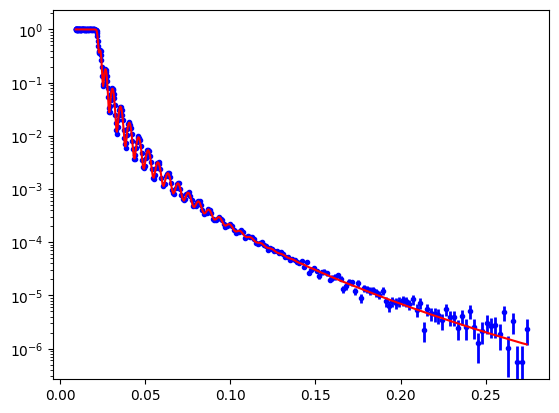

In [4]:
s, model, objective = data.setup_analysis()

objective.plot()
plt.yscale('log')

## View a Structure in terms of the ORSO model language

In [5]:
orso_model = s.to_orso()              # an ORSO SampleModel object

print(orso_model.to_yaml())           # the YAML representation of the SampleModel object.

stack: air | m1 | SiO2 | Si
layers:
  air:
    thickness: 0.0
    roughness: 0.0
    material:
      sld: {real: 0.0, imag: 0.0}
  m1:
    thickness: 1000.0
    roughness: 4.0
    material:
      formula: Ni
      mass_density: 8.9
  SiO2:
    thickness: 10.0
    roughness: 3.0
    material:
      sld: {real: 3.4700000000000002e-06, imag: 0.0}
  Si:
    thickness: 0.0
    roughness: 3.5
    material:
      sld: {real: 2.0699999999999997e-06, imag: 0.0}
globals:
  roughness: {magnitude: 0.3, unit: nm}
  length_unit: angstrom
  mass_density_unit: g/cm^3
  number_density_unit: 1/nm^3
  sld_unit: 1/angstrom^2
  magnetic_moment_unit: muB
reference: ORSO model language | 1.0



## Fitting the ORSO example

Now let's try fitting this data. First of all we need to vary some parameters.

In [6]:
# s[1] is the first slab (Ni) after the fronting (air) medium
s[1].thick.setp(vary=True, bounds=(950, 1050))

for slab in s:
    slab.rough.setp(vary=True, bounds=(2, 6))

# s[2] is the second slab (SiO2) after the fronting medium.
s[2].thick.setp(vary=True, bounds=(5, 20))

# ReflectModel has a background that we'll want to vary
model.bkg.setp(vary=True, bounds=(1e-7, 1e-5))

If you don't know how to figure out what parameters are present you can try examining the Component and printing its Parameters

In [7]:
print(s[1])

________________________________________________________________________________
Parameters:      'm1'      
<Parameter: 'm1 - thick'  , value=1000          , bounds=[950.0, 1050.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   'density'   , value=8.9  (fixed) , bounds=[-inf, inf]>
<Parameter: 'm1 - rough'  , value=4          , bounds=[2.0, 6.0]>
<Parameter:'m1 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


In [8]:
for i, p in enumerate(s[1].parameters.flattened()):
    print(i, p)

0 <Parameter: 'm1 - thick'  , value=1000          , bounds=[950.0, 1050.0]>
1 <Parameter:   'density'   , value=8.9  (fixed) , bounds=[-inf, inf]>
2 <Parameter: 'm1 - rough'  , value=4          , bounds=[2.0, 6.0]>
3 <Parameter:'m1 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


You can see that there's a density parameter, that's because the Slab was setup using a `MaterialSLD` object. The density parameter is the density of the Nickel film. Let's vary the Nickel density in the fit as well.

In [9]:
s[1].parameters.flattened()[1].setp(vary=True, bounds=(8.5, 8.9))

# the following is equivalent, and is straightforward to think about once you're familiar with how refnx works.
# s[1].sld.density.setp(vary=True, bounds=(8.5, 8.9))

-2462.809685994783: : 19it [00:01, 13.12it/s] 


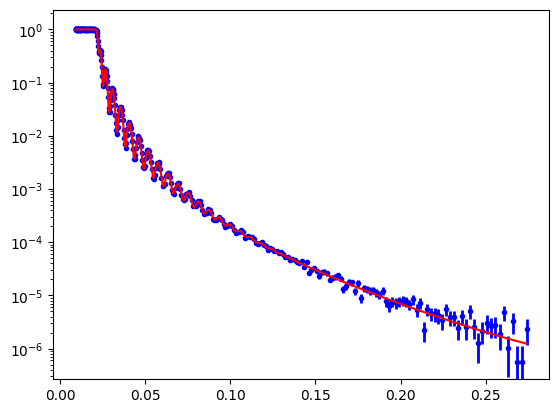

In [10]:
fitter = CurveFitter(objective)
fitter.fit('differential_evolution')
objective.plot()
plt.yscale('log')

## updating the model within the ORSO file using a `Structure`

Once you've fitted the data you'll need to update the model within the original ORSO file, it's not done automatically. This is done by using the `OrsoDataset.update_model` method, you need to supply a `Structure` object to do so. Again, there's no link between the `Structure` originally created by `OrsoDataset.setup_analysis()` and the model contained within the `OrsoDataset`.

Once the update is done you'll need to resave the ORSO file.

In [11]:
data.update_model(s)
data.save("Ni_example_updated.ort")